**Airbnb Image Classification: Identifying if an image can indicate a success of an Airbnb**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import random
import gc # garbage collector
print(os.listdir("../input"))

ModuleNotFoundError: No module named 'cv2'

In [88]:
# Creating the train and test directory 
train_dir = '../input/train_airbnb'
test_dir = '../input/test_airbnb'

# Identify successes
train_success = ['../input/train_airbnb/{}'.format(i) for i in os.listdir(train_dir) if 'success' in i]  
train_not_success = ['../input/train_airbnb/{}'.format(i) for i in os.listdir(train_dir) if 'nots' in i]  

test = ['../input/test_airbnb/{}'.format(i) for i in os.listdir(test_dir)]

train_img = train_success + train_not_success
random.shuffle(train_img)

del train_success
del train_not_success
gc.collect() # Collects garbage to save to memory


3369

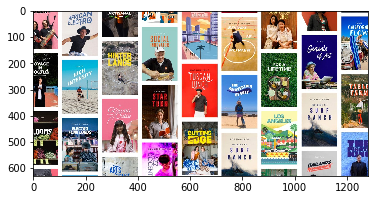

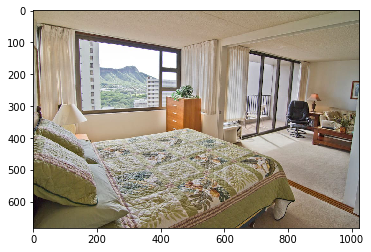

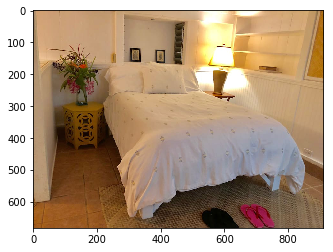

In [72]:
import matplotlib.image as mpimg
for ima in train_img[0:3]:
    img = mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [73]:
# Declaring the image size 
nrows=150
ncolumns = 150
channels = 3 # 3 because we are using a colored image

In [74]:
# Function to read and process the images to an acceptable format 
def read_process_image(list_of_images):
    # returns X (array of resized images) and Y (array of labels)
    X = []
    y = []
    
    for image in list_of_images:
        # Adding image to X
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR),
                            (nrows,ncolumns), interpolation = cv2.INTER_CUBIC))
        # Get the labels 
        if 'success' in image:
            y.append(1)
        elif 'nots' in image:
            y.append(0)
        
    return X, y

In [75]:
X, y = read_process_image(train_img)

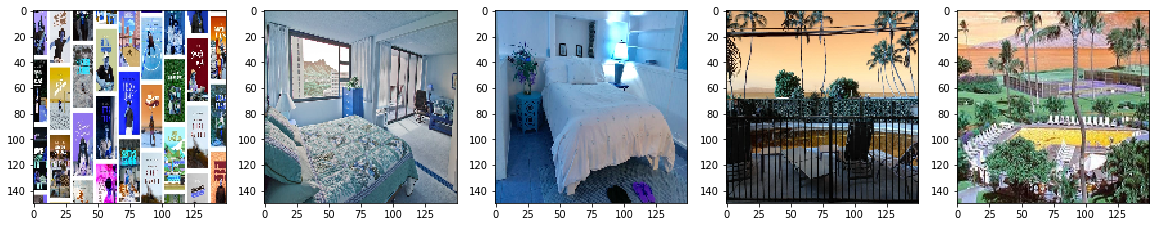

In [76]:
plt.figure(figsize= (20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns+1, columns, i + 1)
    plt.imshow(X[i])

9


Text(0.5, 1.0, 'Labels for Successful Houses')

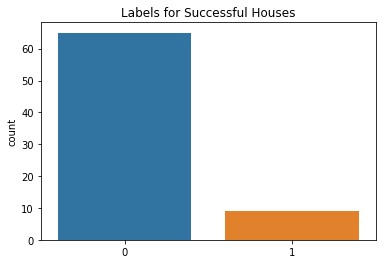

In [77]:
import seaborn as sns 
#del train_img
gc.collect()

# Convert list to numpy array
X = np.array(X)
y = np.array(y)

# Plot the label to be sure we just have two classes
sns.countplot(y)
plt.title('Labels for Successful Houses')

In [46]:
print('Shape of train images is: ', X.shape)
print('Shape of labels is: ', y.shape)

Shape of train images is:  (74, 150, 150, 3)
Shape of labels is:  (74,)


In [47]:
# Split the data into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)  

print('Shape of train images is: ', X_train.shape)
print('Shape of test images is: ', X_test.shape)
print('Shape of train labels is: ', y_train.shape)
print('Shape of test labels is: ', y_test.shape)


Shape of train images is:  (59, 150, 150, 3)
Shape of test images is:  (15, 150, 150, 3)
Shape of train labels is:  (59,)
Shape of test labels is:  (15,)


In [48]:
# Clear Memory 
del X
del y
gc.collect()

# Get the legnth of the train and test data
ntrain = len(X_train)
ntest = len(X_test)

batch_size = 32

In [49]:
# Using Convolutional Neural Network to train our model
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [50]:
# Following a popular and effective architecture called VGGnet
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
# Dropout for regulation
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
# Sigmoid function at the end because we have two classes
model.add(layers.Dense(1, activation='sigmoid'))

In [51]:
# Model Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [52]:
# Compiling our model with RMSprop optimizer with a learning rate of 0.0001 and binary_crossentropy because it is a binary classification
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])    


In [53]:
# Creating the augmentation configuration 
# Helps prevent overfitting
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=40,
                                  width_shift_range = 0.2, height_shift_range = 0.2,
                                  shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True)

# We do not augment the test data and only perform rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [54]:
# Create the image generators 
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size = batch_size)


In [56]:
# Training the data, 32 epochs
history = model.fit_generator(train_generator, steps_per_epoch = ntrain, 
                              epochs = 32, validation_data = test_generator, 
                              validation_steps = ntest)


Epoch 1/32
59/59 [==============================] - 69s 1s/step - loss: 0.3513 - acc: 0.8977 - val_loss: 0.4613 - val_acc: 0.8000
Epoch 2/32
59/59 [==============================] - 69s 1s/step - loss: 0.3168 - acc: 0.8980 - val_loss: 0.4332 - val_acc: 0.8000
Epoch 3/32
59/59 [==============================] - 68s 1s/step - loss: 0.2886 - acc: 0.9029 - val_loss: 0.4159 - val_acc: 0.8000
Epoch 4/32
59/59 [==============================] - 70s 1s/step - loss: 0.2606 - acc: 0.9154 - val_loss: 0.3854 - val_acc: 0.8000
Epoch 5/32
59/59 [==============================] - 69s 1s/step - loss: 0.2333 - acc: 0.9196 - val_loss: 0.4874 - val_acc: 0.8000
Epoch 6/32
59/59 [==============================] - 69s 1s/step - loss: 0.2193 - acc: 0.9264 - val_loss: 0.3758 - val_acc: 0.8667
Epoch 7/32
59/59 [==============================] - 70s 1s/step - loss: 0.1975 - acc: 0.9295 - val_loss: 0.3081 - val_acc: 0.8000
Epoch 8/32
59/59 [==============================] - 69s 1s/step - loss: 0.1752 - acc: 0.93

From the image classifier, we achieved an accuracy of approximately 80% out of the 32 epochs. With the distribution of y_test values being screwed with approximately 60% of the data diplaying pictures of unsuccessful houses, we can say that this image classifer was fairly accurate.

In [57]:
# Save the model 
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

In [ ]:
# Serializing the Model 
import pickle

# Serialize image classifier object into a file called mlp_nn.pkg on disk using pickle
with open('mlp_nn.pkl', 'wb') as handle:
    pickle.dump(model, handle, pickle.HIGHEST_PROTOCOL)

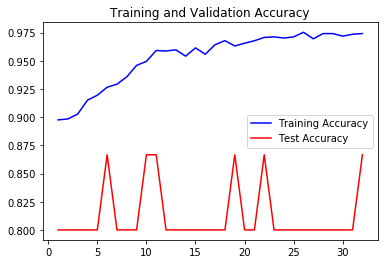

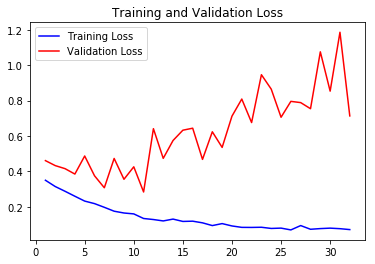

In [78]:
# Plotting the training and test curve 
# Getting the details from the history object 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Train and validation accuracy 
plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

# Train and Validation Loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


From the two graphs above, it appears that we are overfitting the data. The test accuracy is consistently lower than the training accuracy. Therefore, it might be a good idea to go back and look at ways to prevent overfitting of the data. 

In [94]:
# Predict the first 10 images of the test set 
X_test, y_test = read_process_image(test[0:10]) # y_test will be empty 
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

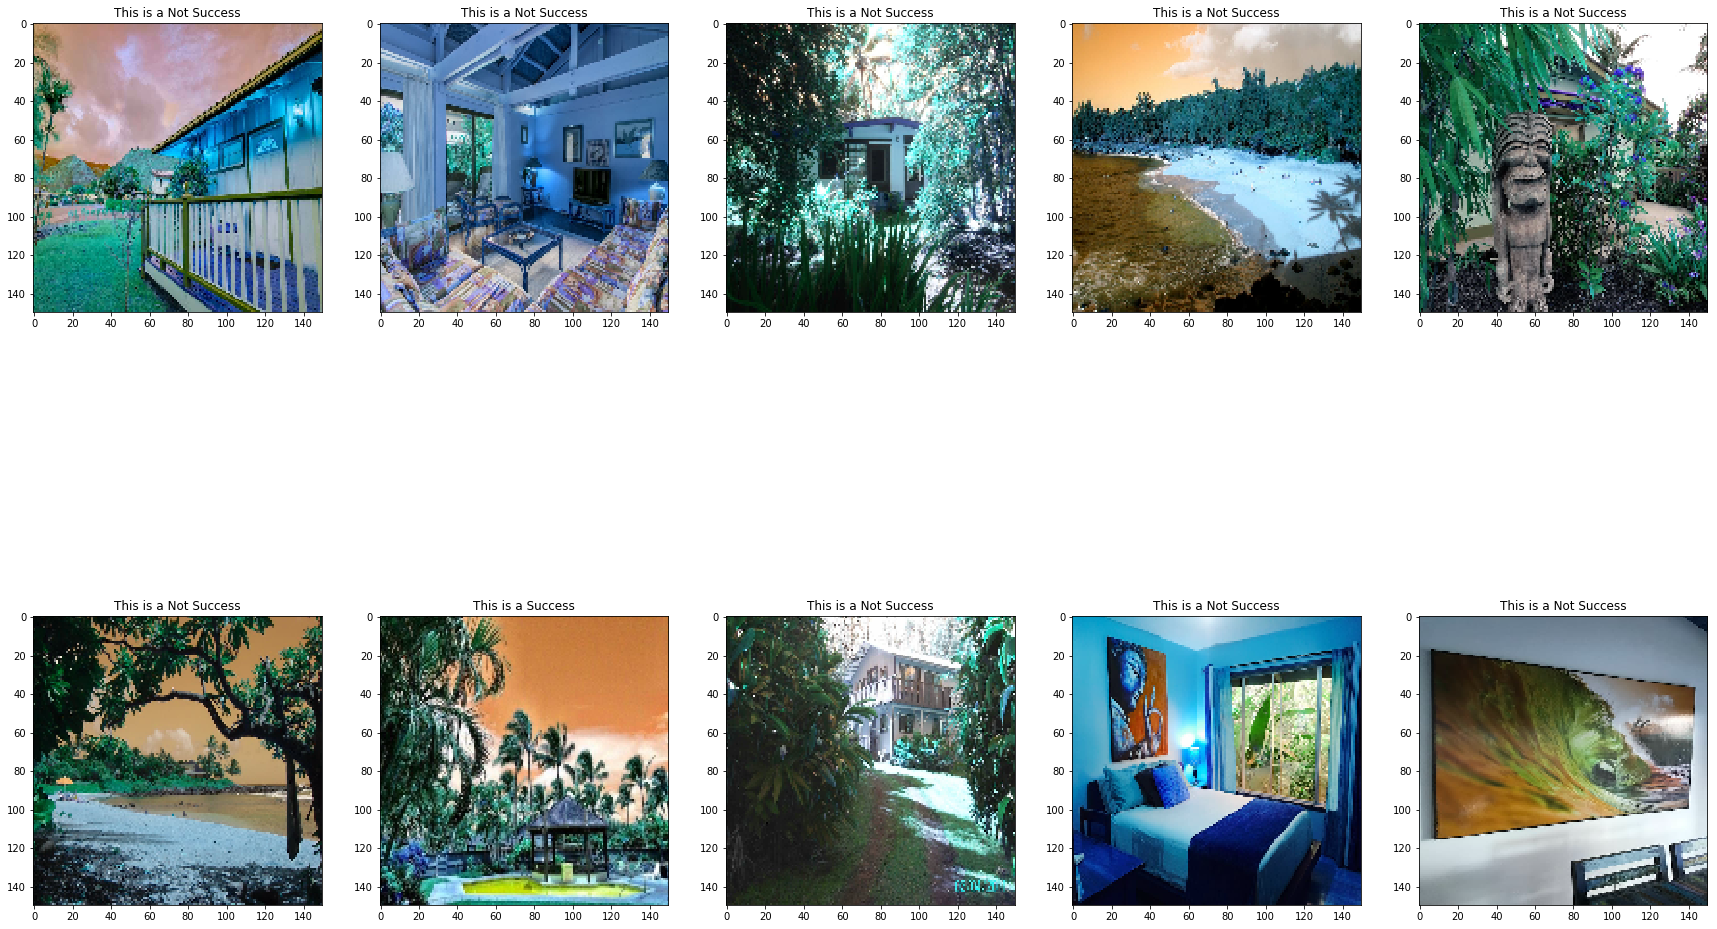

In [95]:
i = 0 
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.6:
        text_labels.append('Success')
    else:
        text_labels.append('Not Success')
    plt.subplot(5/columns+1, columns, i+1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()